## Imports

Import required libraries.

In [1]:
import time
import scipy.io
import mne
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import antropy as ant
import EntropyHub as EH

# Preprocessing

### Load data
Load raw EEG data for normal state of *Person 1* from .cnt file and display general information about data.

**TODO** Load all data for every person

In [2]:
file_name_normal = "data/1/Normal state.cnt"
file_name_fatigue = "data/1/Fatigue state.cnt"

raw_normal = mne.io.read_raw_cnt(file_name_normal, preload=True, verbose=False).load_data()
raw_fatigue = mne.io.read_raw_cnt(file_name_fatigue, preload=True, verbose=False).load_data()

<ipython-input-2-aeee5cce994d>:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw_normal = mne.io.read_raw_cnt(file_name_normal, preload=True, verbose=False).load_data()
<ipython-input-2-aeee5cce994d>:4: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw_normal = mne.io.read_raw_cnt(file_name_normal, preload=True, verbose=False).load_data()
<ipython-input-2-aeee5cce994d>:5: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw_fatigue = mne.io.read_raw_cnt(file_name_fatigue, preload=True, verbose=False).load_data()
/home/satan/.local/lib/python3.9/site-packages/mne/io/cnt/cnt.py:241: RuntimeWarning: overflow encountered in int_scalars
  data_size // (n_samples * n_channels) not in [2, 4]):
<ipython-input-2-aeee5cce994d>:5: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw_fatigue = mne.io.read_raw_cnt(file_name_fatigue, preload=True, verbose

In [3]:
raw_normal.info

<Info | 8 non-empty values
 bads: []
 ch_names: HEOL, HEOR, FP1, FP2, VEOU, VEOL, F7, F3, FZ, F4, F8, FT7, FC3, ...
 chs: 40 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: unspecified
 nchan: 40
 projs: []
 sfreq: 1000.0 Hz
 subject_info: 5 items (dict)
>

In [4]:
raw_fatigue.info

<Info | 8 non-empty values
 bads: []
 ch_names: HEOL, HEOR, FP1, FP2, VEOU, VEOL, F7, F3, FZ, F4, F8, FT7, FC3, ...
 chs: 40 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: unspecified
 nchan: 40
 projs: []
 sfreq: 1000.0 Hz
 subject_info: 5 items (dict)
>

Display PSD chart. A Power Spectral Density (PSD) is the measure of signal's power content versus frequency. At the beginning the data is not very readable.

<ipython-input-5-7a97954e97b1>:1: UserWarning: Infinite value in PSD for channels HEOR, FP2, F3, FT8, C3, C4, TP7, TP8, PZ, PO2.
These channels might be dead.
  raw_normal.plot_psd()


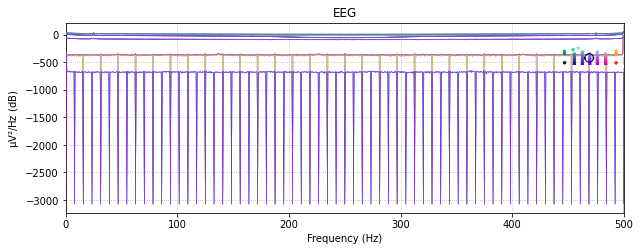

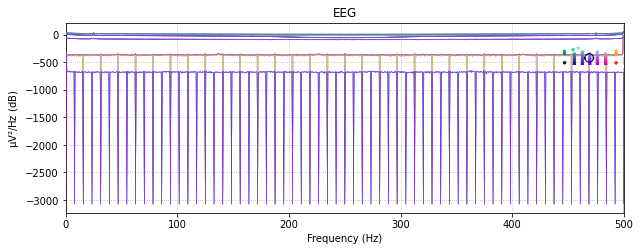

In [5]:
raw_normal.plot_psd()

<ipython-input-6-f63b797d633f>:1: UserWarning: Infinite value in PSD for channels FP2, VEOL, F3, F4, FT7, C3, C4, CPZ, T5, PZ, T6, PO2.
These channels might be dead.
  raw_fatigue.plot_psd()


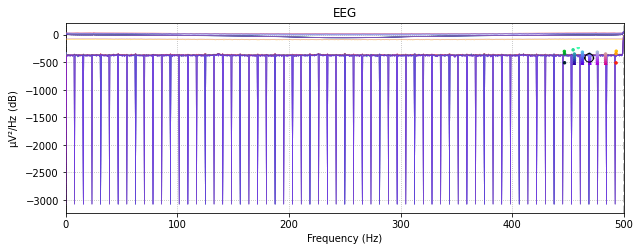

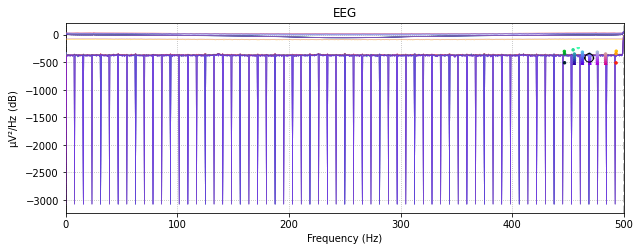

In [6]:
raw_fatigue.plot_psd()

### Crop signal

The original signal duration is ten minutes. Cut out the first five mintues as paper states only the last five minutes is used.

Also, because of the noise, do not take the last 20 seconds into account.

In [7]:
raw_normal.crop(tmin=280, tmax=580)

<RawCNT | Normal state.cnt, 40 x 300001 (300.0 s), ~91.6 MB, data loaded>

In [8]:
raw_fatigue.crop(tmin=280, tmax=580)

<RawCNT | Fatigue state.cnt, 40 x 300001 (300.0 s), ~91.6 MB, data loaded>

### Clean channels
Extract thirty channels mentioned in the paper, remove all other channels from the dataset.

After this step, only thirty EEG channels should remain.

In [9]:
goods_ch = set(['FP1', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8', 'FT7', 'FC3', 'FCZ', 'FC4', 'FT8', 'T3', 'C3', 'CZ', 'C4', 'T4', 'TP7', 'CP3', 'CPZ', 'CP4', 'TP8', 'T5', 'P3', 'PZ', 'P4', 'T6', 'O1', 'OZ', 'O2'])

all_ch_normal = set(raw_normal.info["ch_names"])
bads_ch_normal = list(all_ch_normal - goods_ch)

all_ch_fatigue = set(raw_fatigue.info["ch_names"])
bads_ch_fatigue = list(all_ch_fatigue - goods_ch)

raw_normal.info["bads"].extend(bads_ch_normal)
raw_normal.pick_channels(goods_ch)

raw_fatigue.info["bads"].extend(bads_ch_fatigue)
raw_fatigue.pick_channels(goods_ch)

<RawCNT | Fatigue state.cnt, 30 x 300001 (300.0 s), ~68.7 MB, data loaded>

### Filter
Apply notch filter to remove power-line noise. Power-line noise is a noise created by the electrical network and it is composed of sharp peaks at 50Hz. Some peaks may also be present at the harmonic frequencies, i.e. the integer multiples of the power-line frequency, e.g. 100Hz, 150Hz ...

Exclude bad channels and apply the filter only on good channels.

In [10]:
picks_normal = mne.pick_types(raw_normal.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')

raw_normal.notch_filter(np.arange(50, 251, 50), picks=picks_normal)

<RawCNT | Normal state.cnt, 30 x 300001 (300.0 s), ~68.7 MB, data loaded>

In [11]:
picks_fatigue = mne.pick_types(raw_fatigue.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')

raw_fatigue.notch_filter(np.arange(50, 251, 50), picks=picks_fatigue)

<RawCNT | Fatigue state.cnt, 30 x 300001 (300.0 s), ~68.7 MB, data loaded>

Display PSD chart after applying the notch filter.

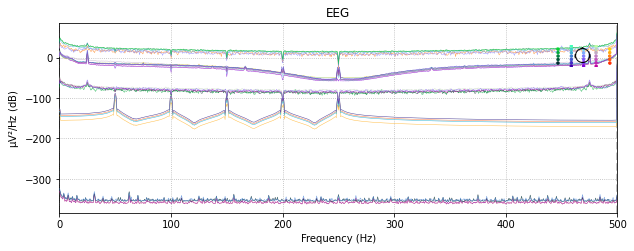

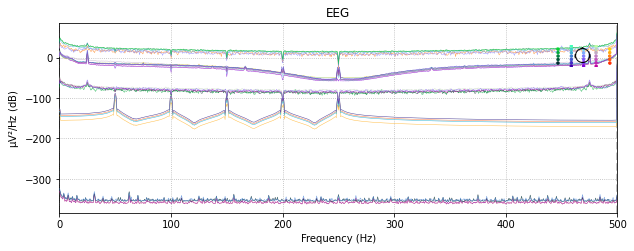

In [12]:
raw_normal.plot_psd()

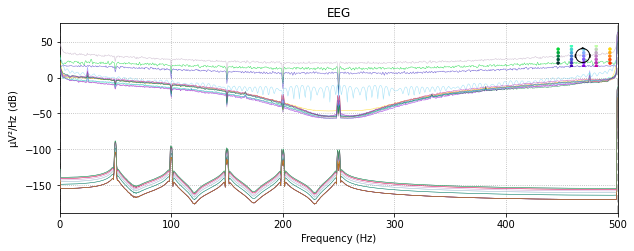

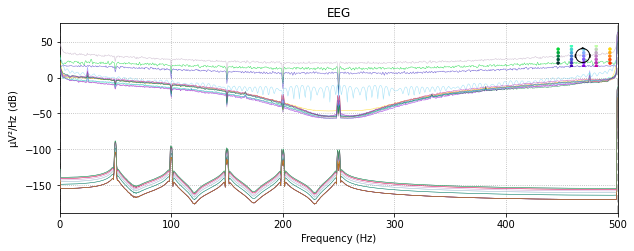

In [13]:
raw_fatigue.plot_psd()

Apply band pass filter to remove additional noise.

In [14]:
raw_normal.filter(0.15, 40)

<RawCNT | Normal state.cnt, 30 x 300001 (300.0 s), ~68.7 MB, data loaded>

In [15]:
raw_fatigue.filter(0.15, 40)

<RawCNT | Fatigue state.cnt, 30 x 300001 (300.0 s), ~68.7 MB, data loaded>

Display PSD chart after applying the band pass filter.

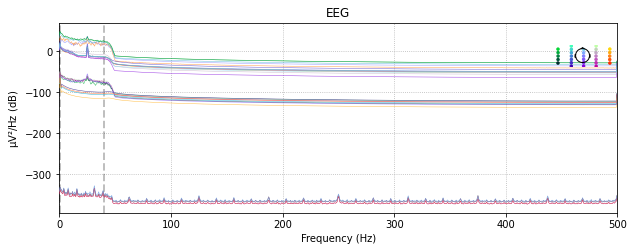

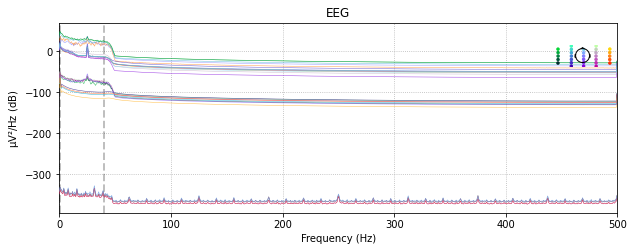

In [16]:
raw_normal.plot_psd()

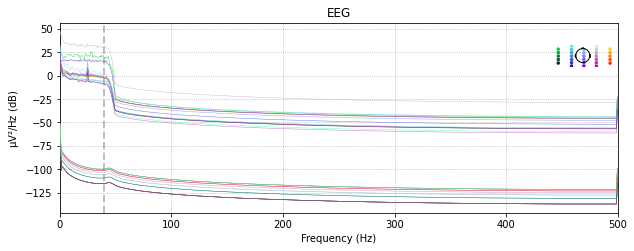

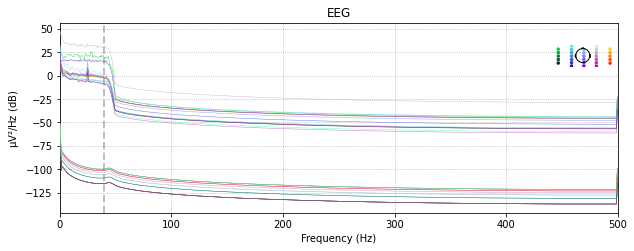

In [17]:
raw_fatigue.plot_psd()

Display the raw data plot after preprocessing.

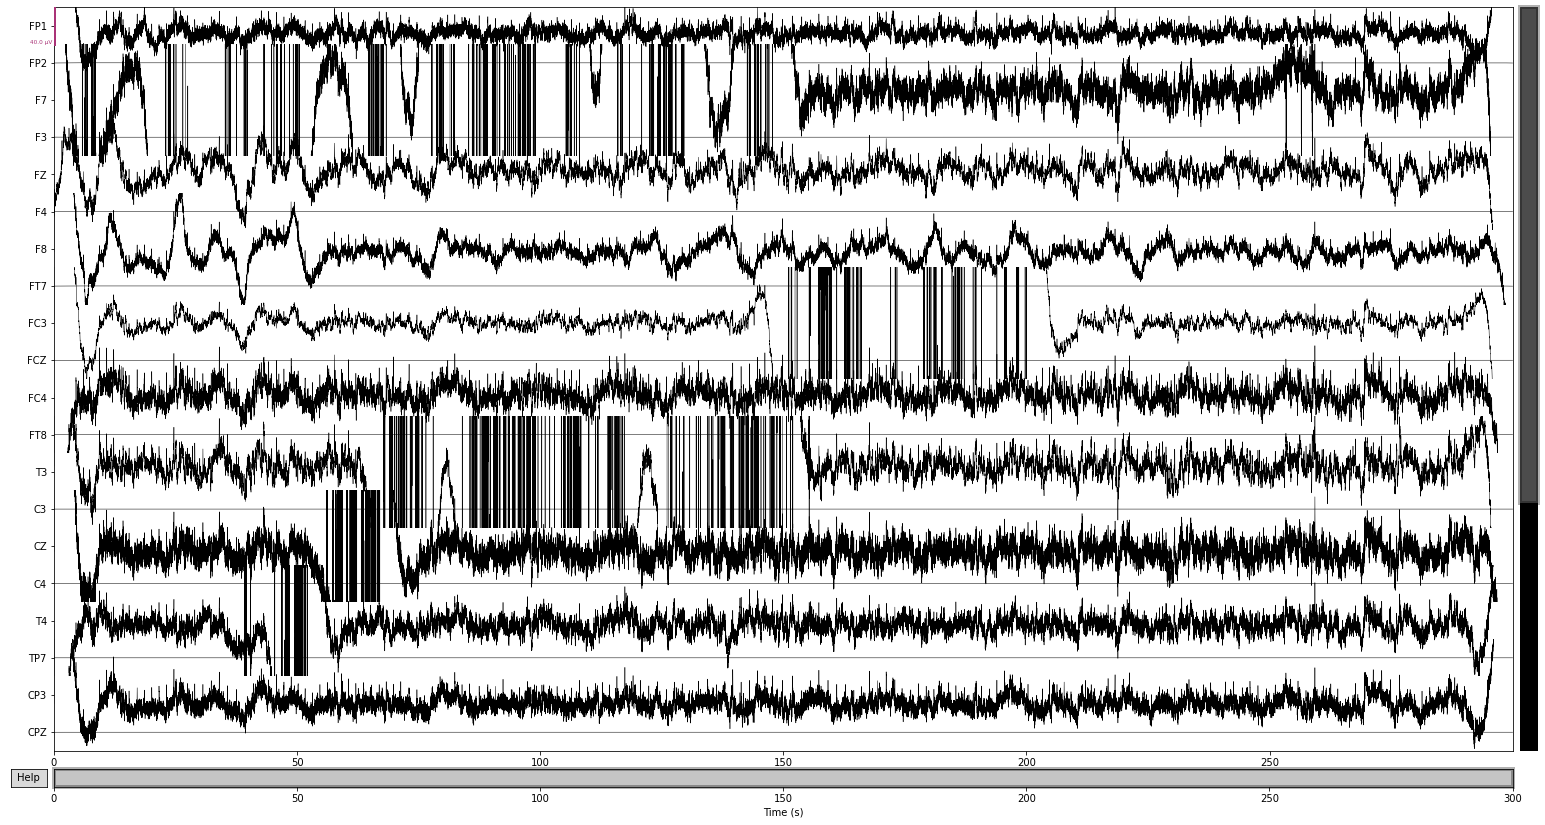

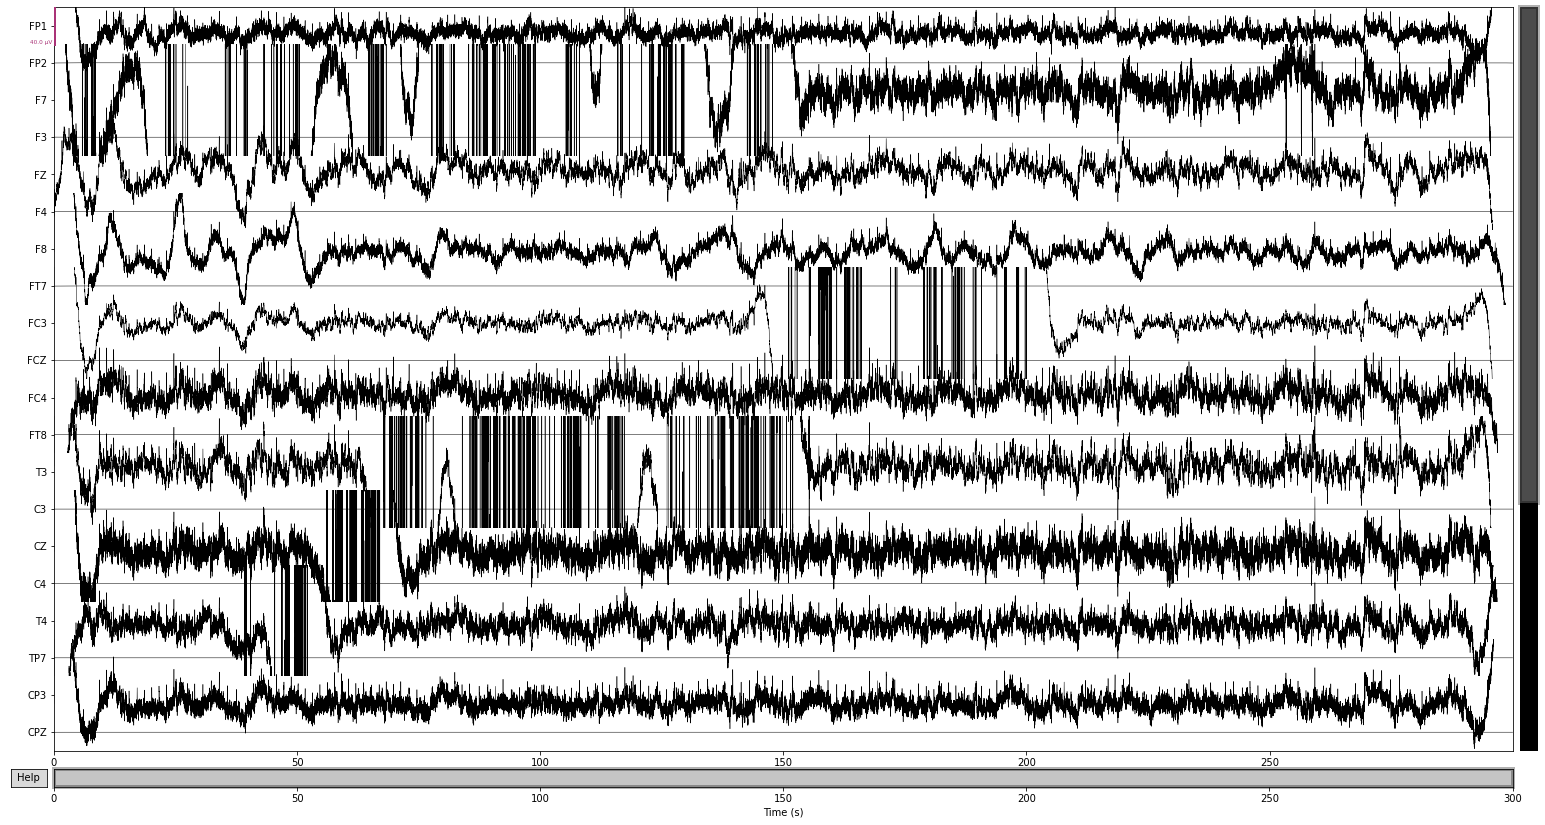

In [18]:
raw_normal.plot(start=0, duration=300, show=True)

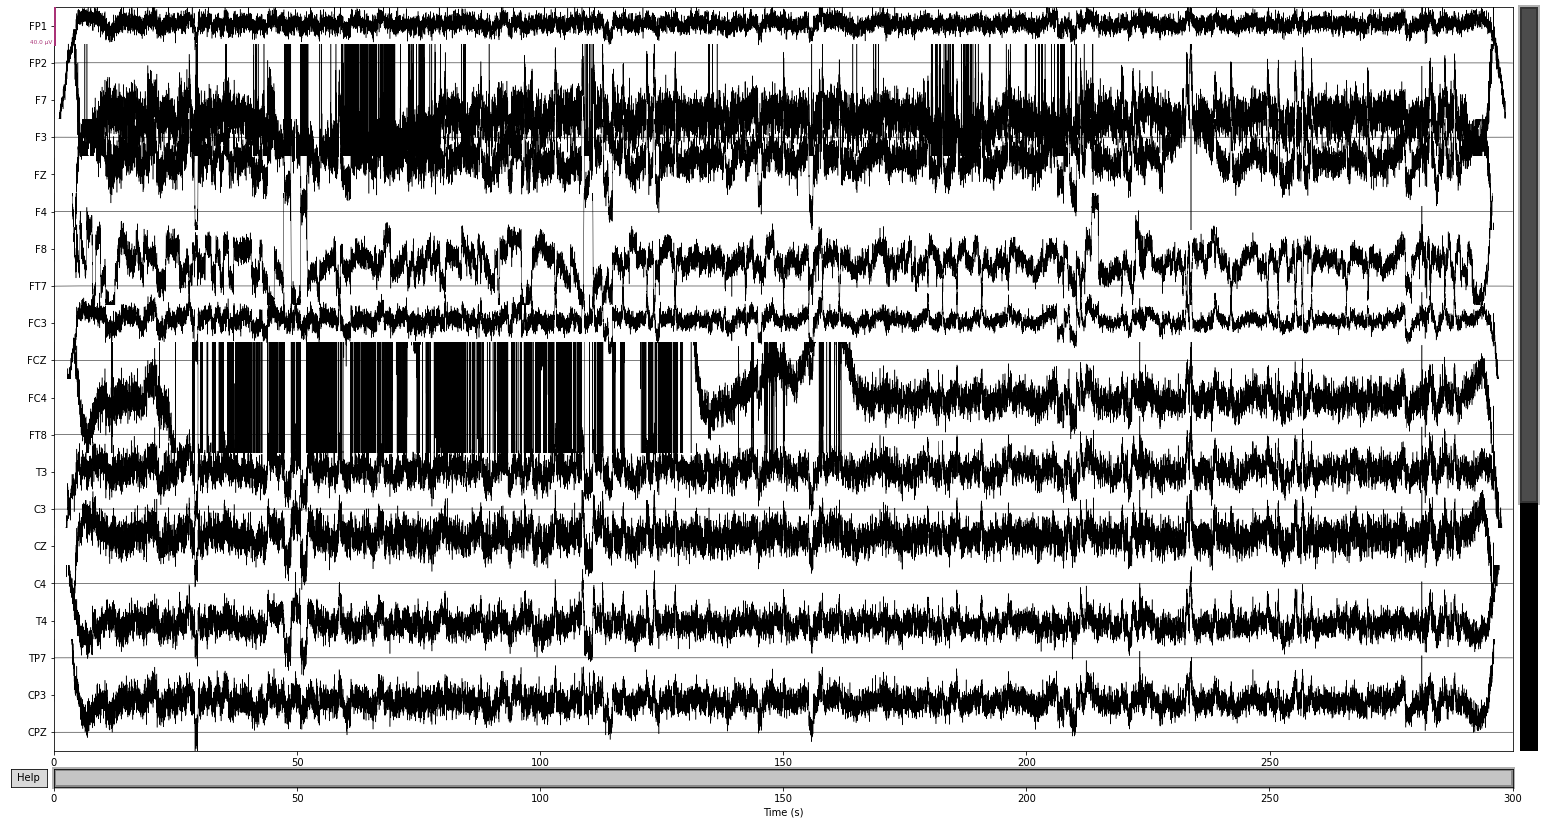

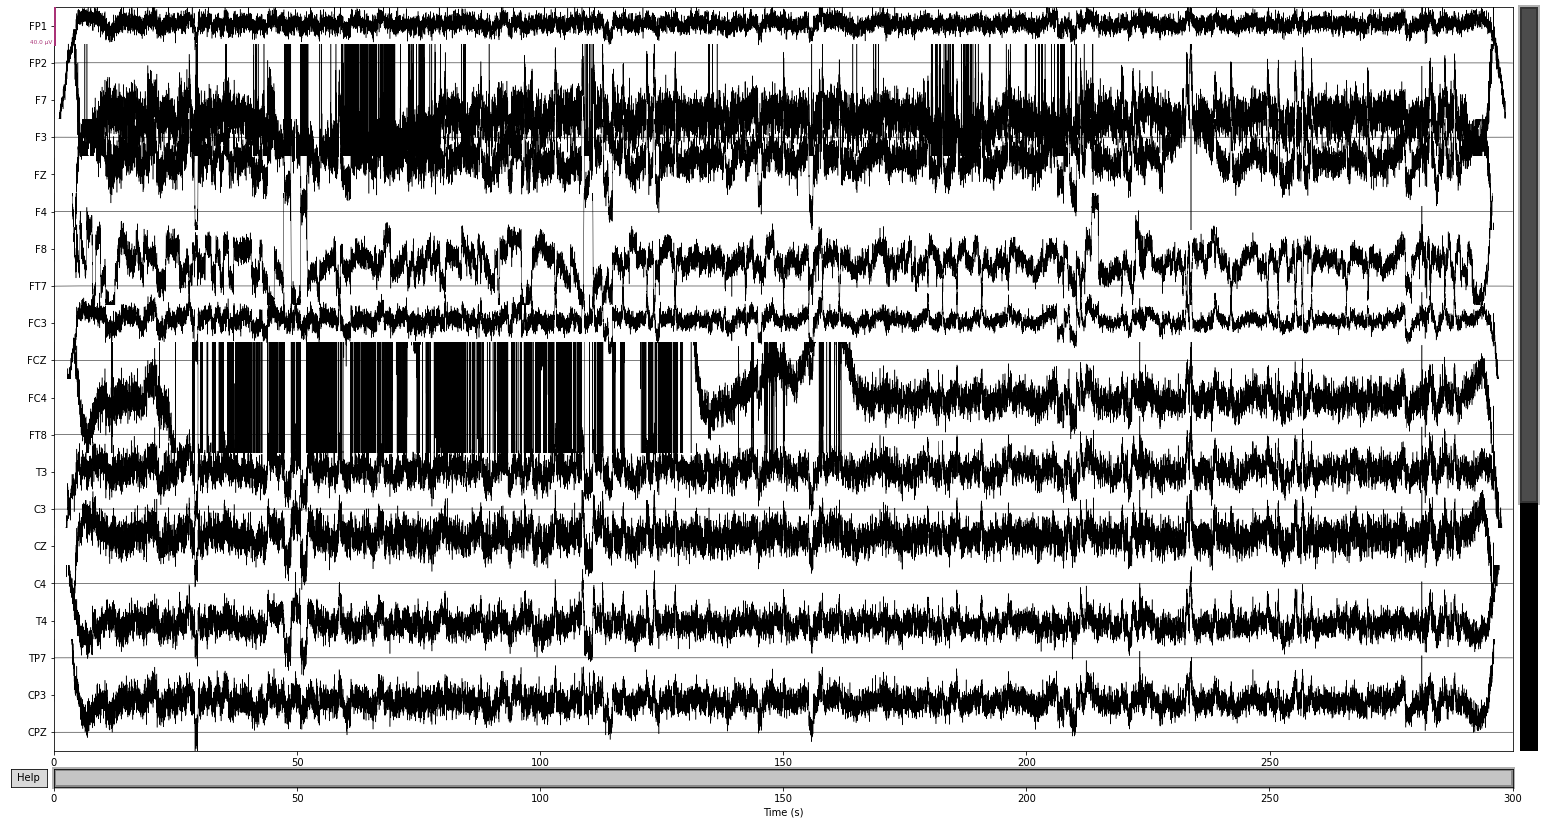

In [19]:
raw_fatigue.plot(start=0, duration=300, show=True)

### Create epochs

Section data into 1 second epochs to produce 300 epochs for each channel (30 channels) in total.

After this step every epoch should consist of 1000 numbers.

In [20]:
epoch_duration = 1

epochs_normal = mne.make_fixed_length_epochs(raw_normal, duration=epoch_duration, preload=True)
epochs_fatigue = mne.make_fixed_length_epochs(raw_fatigue, duration=epoch_duration, preload=True)

structured_data_normal = epochs_normal.get_data()
structured_data_fatigue = epochs_fatigue.get_data()

Not setting metadata
Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated
Loading data for 300 events and 1000 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated
Loading data for 300 events and 1000 original time points ...
0 bad epochs dropped


In [21]:
# verify results
num_epochs = 300
num_channels = 30
num_raw_data = 1000

assert(structured_data_normal.shape[0] == num_epochs)
assert(structured_data_normal.shape[1] == num_channels)
assert(structured_data_normal.shape[2] == num_raw_data)

assert(structured_data_fatigue.shape[0] == num_epochs)
assert(structured_data_fatigue.shape[1] == num_channels)
assert(structured_data_fatigue.shape[2] == num_raw_data)

# Feature extraction and classifiers

### Calculate entropy

Calculate AE, PE, SE and FE for each epoch for every channel. Store results in separate matrices both for normal and fatigue state.

In [22]:
AE_normal_matrix = np.zeros(shape=(num_epochs, num_channels, 1))
PE_normal_matrix = np.zeros(shape=(num_epochs, num_channels, 1))
SE_normal_matrix = np.zeros(shape=(num_epochs, num_channels, 1))
FE_normal_matrix = np.zeros(shape=(num_epochs, num_channels, 1))

AE_fatigue_matrix = np.zeros(shape=(num_epochs, num_channels, 1))
PE_fatigue_matrix = np.zeros(shape=(num_epochs, num_channels, 1))
SE_fatigue_matrix = np.zeros(shape=(num_epochs, num_channels, 1))
FE_fatigue_matrix = np.zeros(shape=(num_epochs, num_channels, 1))

In [23]:
for epoch_num in range(num_epochs):
    for channel_num in range(num_channels):
        
        # extract data array for each state
        data_normal = structured_data_normal[epoch_num][channel_num]
        data_fatigue = structured_data_fatigue[epoch_num][channel_num]
        
        # calculate entropies for normal state
        AE_normal = ant.app_entropy(data_normal)
        PE_normal = ant.spectral_entropy(data_normal, sf=1000)
        SE_normal = ant.sample_entropy(data_normal)
        r_normal = np.std(data_normal, ddof=1) * 0.2
        FE_normal = (EH.FuzzEn(data_normal, m=2, r=(r_normal,1)))[0][-1]
        
        # fill matrix with entropies for normal state
        AE_normal_matrix[epoch_num][channel_num] = AE_normal
        PE_normal_matrix[epoch_num][channel_num] = PE_normal
        SE_normal_matrix[epoch_num][channel_num] = SE_normal
        FE_normal_matrix[epoch_num][channel_num] = FE_normal
        
        # calculate entropies for fatigue state
        AE_fatigue = ant.app_entropy(data_fatigue)
        PE_fatigue = ant.spectral_entropy(data_fatigue, sf=1000)
        SE_fatigue = ant.sample_entropy(data_fatigue)
        r_fatigue = np.std(data_fatigue, ddof=1) * 0.2
        FE_fatigue = (EH.FuzzEn(data_fatigue, m=2, r=(r_fatigue,1)))[0][-1]
        
        # fill matrix with entropies for fatigue state
        AE_fatigue_matrix[epoch_num][channel_num] = AE_fatigue
        PE_fatigue_matrix[epoch_num][channel_num] = PE_fatigue
        SE_fatigue_matrix[epoch_num][channel_num] = SE_fatigue
        FE_fatigue_matrix[epoch_num][channel_num] = FE_fatigue

/home/satan/.local/lib/python3.9/site-packages/antropy/entropy.py:249: RuntimeWarning: divide by zero encountered in log2
  se = -(psd_norm * np.log2(psd_norm)).sum(axis=axis)
/home/satan/.local/lib/python3.9/site-packages/antropy/entropy.py:249: RuntimeWarning: invalid value encountered in multiply
  se = -(psd_norm * np.log2(psd_norm)).sum(axis=axis)


In [24]:
np.save("data/1/AE_normal_matrix", AE_normal_matrix)
np.save("data/1/PE_normal_matrix", PE_normal_matrix)
np.save("data/1/SE_normal_matrix", SE_normal_matrix)
np.save("data/1/FE_normal_matrix", FE_normal_matrix)

np.save("data/1/AE_fatigue_matrix", AE_fatigue_matrix)
np.save("data/1/PE_fatigue_matrix", PE_fatigue_matrix)
np.save("data/1/SE_fatigue_matrix", SE_fatigue_matrix)
np.save("data/1/FE_fatigue_matrix", FE_fatigue_matrix)